In [ ]:
# Global data variables
# SANDBOX_NAME = '' # Sandbox Name
# DATA_PATH = "/data/sandboxes/" + SANDBOX_NAME + "/data/data/" 

In [ ]:
!apt-get install openjdk-8-jdk -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
import findspark
from google.colab import drive, auth
findspark.init("spark-3.0.2-bin-hadoop2.7") # SPARK_HOME
from pyspark.sql import SparkSession
spark =  SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
!apt-get install openjdk-8-jdk -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

import findspark
from google.colab import drive, auth
findspark.init("spark-3.0.2-bin-hadoop2.7") # SPARK_HOME
from pyspark.sql import SparkSession
spark =  SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH='/content/sample_data/'

 

# Análisis de Datos Exploratorio

Lo pasos mas típicos en el análisis de datos exploratorio son los siguientes:

* Análisis Univariante
    * Tecnicas numéricas
    * Técnicas gráficas
    
* Análisis Multivariante
    * Técnicas numéricas
    * Técnicas gráficas
    
* Detección de outliers

* Tests de hipótesis

En el caso de Spark es menos común utilizar técnicas gráficas ya que muchas de estas requieren tener todos los datos en el driver. Más adelante se mostrarán formas de precalcular en Spark los datos de las gráficas o de realizar muestreos para su representación.



## Análisis Univariante
### Variables cuantitativas

Las métricas clásicas para variables cuantitativas son: media, desviación, máximo, mínimo, mediana y quartiles.

In [ ]:
from pyspark.sql import functions as F

In [ ]:
pokemon_df = spark.read.csv(DATA_PATH + 'pokemon.csv', sep=',', header=True, inferSchema=True)

In [ ]:
pokemon_df = pokemon_df.withColumnRenamed('Sp. Atk', 'Sp Atk').withColumnRenamed('Sp. Def', 'Sp Def')

In [ ]:
pokemon_df.show(3)

+---------+------+------+---+------+-------+------+------+-----+----------+---------+
|     Name|Type 1|Type 2| HP|Attack|Defense|Sp Atk|Sp Def|Speed|Generation|Legendary|
+---------+------+------+---+------+-------+------+------+-----+----------+---------+
|Bulbasaur| Grass|Poison| 45|    49|     49|    65|    65|   45|         1|    false|
|  Ivysaur| Grass|Poison| 60|    62|     63|    80|    80|   60|         1|    false|
| Venusaur| Grass|Poison| 80|    82|     83|   100|   100|   80|         1|    false|
+---------+------+------+---+------+-------+------+------+-----+----------+---------+
only showing top 3 rows



In [ ]:
pokemon_df.dtypes

[('Name', 'string'),
 ('Type 1', 'string'),
 ('Type 2', 'string'),
 ('HP', 'int'),
 ('Attack', 'int'),
 ('Defense', 'int'),
 ('Sp Atk', 'int'),
 ('Sp Def', 'int'),
 ('Speed', 'int'),
 ('Generation', 'int'),
 ('Legendary', 'boolean')]



Primero identifica variables cualitativas y cuantitativas.

In [ ]:
quantitative_vars = [c for c,t in pokemon_df.dtypes if t in ['int', 'double']]
qualitative_vars = [c for c,t in pokemon_df.dtypes if t in ['boolean', 'string']]

In [ ]:
quantitative_vars

['HP', 'Attack', 'Defense', 'Sp Atk', 'Sp Def', 'Speed', 'Generation']

In [ ]:
qualitative_vars

['Name', 'Type 1', 'Type 2', 'Legendary']

 

Calcula métricas para una única columna

In [ ]:
pokemon_df.select(F.avg('Attack')).first()

Row(avg(Attack)=79.00125)

In [ ]:
pokemon_df.select(F.avg('Attack')).first()[0]

79.00125

In [ ]:
pokemon_df.select((F.max('HP') - F.min('HP')).alias('range')).show()

+-----+
|range|
+-----+
|  254|
+-----+





Calcula la media, el máximo y el mínimo de la columna `Attack`.

In [ ]:
pokemon_df.select(F.avg('Attack'), F.max('Attack'), F.min('Attack')).first()

Row(avg(Attack)=79.00125, max(Attack)=190, min(Attack)=5)



Calcula la media, el máximo, el mínimo y el rango de la columna `Attack`.

In [ ]:
pokemon_df.select(F.avg('Attack').alias('avg_attack'), 
                  F.max('Attack').alias('max_attack'), 
                  F.min('Attack').alias('min_attack'), 
                (F.max('Attack')-F.min('Attack')).alias('range')).show()

+----------+----------+----------+-----+
|avg_attack|max_attack|min_attack|range|
+----------+----------+----------+-----+
|  79.00125|       190|         5|  185|
+----------+----------+----------+-----+





Es importante recordar que en Spark hay que juntar el máximo número de operaciones antes de realizar una acción. Por tanto para calcular las métricas de todas las columnas es mejor intentar hacerlo en la misma transformación.



Calcula la media de todas las columnas.
Si aplicamos una acción por columna, en un bucle `for`:

In [ ]:
%%time

for col in quantitative_vars:
    avg = pokemon_df.select(F.avg(col)).first()[0]
    print(col, avg)

HP 69.25875
Attack 79.00125
Defense 73.8425
Sp Atk 72.82
Sp Def 71.9025
Speed 68.2775
Generation 3.32375
CPU times: user 32.4 ms, sys: 6.11 ms, total: 38.5 ms
Wall time: 1.36 s




Una acción para todas las columnas. Se pueden definir las operaciones a realizar en una lista y pasársela al método `select`.

In [ ]:
[F.avg(col) for col in quantitative_vars]

[Column<b'avg(HP)'>,
 Column<b'avg(Attack)'>,
 Column<b'avg(Defense)'>,
 Column<b'avg(Sp Atk)'>,
 Column<b'avg(Sp Def)'>,
 Column<b'avg(Speed)'>,
 Column<b'avg(Generation)'>]

In [ ]:
%%time 

pokemon_df.select([F.avg(col) for col in quantitative_vars]).show()

+--------+-----------+------------+-----------+-----------+----------+---------------+
| avg(HP)|avg(Attack)|avg(Defense)|avg(Sp Atk)|avg(Sp Def)|avg(Speed)|avg(Generation)|
+--------+-----------+------------+-----------+-----------+----------+---------------+
|69.25875|   79.00125|     73.8425|      72.82|    71.9025|   68.2775|        3.32375|
+--------+-----------+------------+-----------+-----------+----------+---------------+

CPU times: user 6.73 ms, sys: 859 µs, total: 7.59 ms
Wall time: 558 ms




Para calcular multiples métricas en multiples columnas de forma eficiente se pueden juntar listas de operaciones.
Crea un dataframe con una nueva columna por cada transformación: media, la desviación estandar, los máximos y los mínimos de cada variable cuantitativa.

In [ ]:
avgs = [F.avg(col).alias('avg_' + col) for col in quantitative_vars]
maxs = [F.max(col).alias('max_' + col) for col in quantitative_vars]
mins = [F.min(col).alias('min_' + col) for col in quantitative_vars]
stds = [F.stddev(col).alias('std_' + col) for col in quantitative_vars]

In [ ]:
operations = avgs + stds + maxs + mins 
operations

[Column<b'avg(HP) AS `avg_HP`'>,
 Column<b'avg(Attack) AS `avg_Attack`'>,
 Column<b'avg(Defense) AS `avg_Defense`'>,
 Column<b'avg(Sp Atk) AS `avg_Sp Atk`'>,
 Column<b'avg(Sp Def) AS `avg_Sp Def`'>,
 Column<b'avg(Speed) AS `avg_Speed`'>,
 Column<b'avg(Generation) AS `avg_Generation`'>,
 Column<b'stddev_samp(HP) AS `std_HP`'>,
 Column<b'stddev_samp(Attack) AS `std_Attack`'>,
 Column<b'stddev_samp(Defense) AS `std_Defense`'>,
 Column<b'stddev_samp(Sp Atk) AS `std_Sp Atk`'>,
 Column<b'stddev_samp(Sp Def) AS `std_Sp Def`'>,
 Column<b'stddev_samp(Speed) AS `std_Speed`'>,
 Column<b'stddev_samp(Generation) AS `std_Generation`'>,
 Column<b'max(HP) AS `max_HP`'>,
 Column<b'max(Attack) AS `max_Attack`'>,
 Column<b'max(Defense) AS `max_Defense`'>,
 Column<b'max(Sp Atk) AS `max_Sp Atk`'>,
 Column<b'max(Sp Def) AS `max_Sp Def`'>,
 Column<b'max(Speed) AS `max_Speed`'>,
 Column<b'max(Generation) AS `max_Generation`'>,
 Column<b'min(HP) AS `min_HP`'>,
 Column<b'min(Attack) AS `min_Attack`'>,
 Column<b

In [ ]:
results = pokemon_df.select(operations).first()

for col in quantitative_vars:
    
    avg = results['avg_' + col]
    std = results['std_' + col]
    maxi = results['max_' + col]
    mini = results['min_' + col]
    
    print('{}: avg={}, std={}, min={}, max={}'.format(col, round(avg, 2), round(std, 2), mini, maxi))

HP: avg=69.26, std=25.53, min=1, max=255
Attack: avg=79.0, std=32.46, min=5, max=190
Defense: avg=73.84, std=31.18, min=5, max=230
Sp Atk: avg=72.82, std=32.72, min=10, max=194
Sp Def: avg=71.9, std=27.83, min=20, max=230
Speed: avg=68.28, std=29.06, min=5, max=180
Generation: avg=3.32, std=1.66, min=1, max=6




__Mediana y cuantiles__

El caso de los cuantiles es un poco especial ya que requieren la ordenación de todo el DataFrame en base a una columna, por tanto no se pueden calcular los cuantiles de varias variables a la vez. Además, el método `approxQuantile` es una **acción**.



Calcula la mediana (cuartil 50%) de la variable `Defense`

In [ ]:
median = pokemon_df.approxQuantile('Defense', [0.5], relativeError=0.01)[0]
median

70.0

In [ ]:
pokemon_df.approxQuantile('Defense', [0.25, 0.5, 0.75], relativeError=0.01)

[50.0, 70.0, 90.0]



Calcula Q1, mediana, Q3 y el rango intercuartílico de la variable `Defense`

In [ ]:
q1, median, q3 = pokemon_df.approxQuantile('Defense', [0.25, 0.5, 0.75], relativeError=0.01)

In [ ]:
q1

50.0

In [ ]:
median

70.0

In [ ]:
q3

90.0

In [ ]:
iqr = q3 - q1
iqr

40.0



### Variables cualitativas

Para variables cualitativas se calculan tablas de frecuencia.



Calcula la tabla de frecuencia de la columna `Type 1`, y ordénala de mayor a menor.

In [ ]:
pokemon_df.groupBy('Type 1').count().show()

+--------+-----+
|  Type 1|count|
+--------+-----+
|   Water|  112|
|  Poison|   28|
|   Steel|   27|
|    Rock|   44|
|     Ice|   24|
|   Ghost|   32|
|   Fairy|   17|
| Psychic|   57|
|  Dragon|   32|
|  Flying|    4|
|     Bug|   69|
|Electric|   44|
|    Fire|   52|
|  Ground|   32|
|    Dark|   31|
|Fighting|   27|
|   Grass|   70|
|  Normal|   98|
+--------+-----+



In [ ]:
pokemon_df.groupBy('Type 1').count().sort(F.col('count').desc()).show()

+--------+-----+
|  Type 1|count|
+--------+-----+
|   Water|  112|
|  Normal|   98|
|   Grass|   70|
|     Bug|   69|
| Psychic|   57|
|    Fire|   52|
|    Rock|   44|
|Electric|   44|
|   Ghost|   32|
|  Dragon|   32|
|  Ground|   32|
|    Dark|   31|
|  Poison|   28|
|Fighting|   27|
|   Steel|   27|
|     Ice|   24|
|   Fairy|   17|
|  Flying|    4|
+--------+-----+





Obtener el valor más repetido.

In [ ]:
result = pokemon_df.groupBy('Type 1').count().sort(F.col('count').desc()).first()
result

Row(Type 1='Water', count=112)

In [ ]:
top_type, top_value = result

In [ ]:
print('Most common type is {} with {} times'.format(top_type, top_value))

Most common type is Water with 112 times




## Análisis Multivariante

Para analizar la relación entre variables continuas se utilizan las correlaciones.



__Correlación entre dos variables__

En este caso, calcula la existente entre `Attack` y `Defense`

In [ ]:
pokemon_df.select(F.corr(F.col('Attack'), F.col('Defense'))).show()

+---------------------+
|corr(Attack, Defense)|
+---------------------+
|   0.4386870551184902|
+---------------------+





__Correlación una variable contra todas__

En este caso, de `Attack` con todas. Este método es interesante de cara a selección de variables para modelos de machine learning. 

In [ ]:
attack_corrs = pokemon_df.select([F.corr(F.col('Attack'), F.col(c)).alias(c) for c in quantitative_vars])
attack_corrs.toPandas()

,HP,Attack,Defense,Sp Atk,Sp Def,Speed,Generation
0,0.422386,1.0,0.438687,0.396362,0.26399,0.38124,0.051451




__Matriz de correlación__

In [ ]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics
import pandas as pd



_Calcula corr sobre RDDs con Vectors_. En este caso se realiza así porque faltan conocimientos por impartir para poder hacerlo con dataframes.

In [ ]:
corr_matrix = Statistics.corr(pokemon_df.select(quantitative_vars).rdd.map(lambda v: Vectors.dense(v)), 
                              method='pearson')
corr_matrix

array([[ 1.        ,  0.42238603,  0.23962232,  0.36237986,  0.37871807,
         0.17595206,  0.05868251],
       [ 0.42238603,  1.        ,  0.43868706,  0.39636176,  0.26398955,
         0.38123974,  0.05145134],
       [ 0.23962232,  0.43868706,  1.        ,  0.22354861,  0.51074659,
         0.0152266 ,  0.04241857],
       [ 0.36237986,  0.39636176,  0.22354861,  1.        ,  0.50612142,
         0.47301788,  0.03643683],
       [ 0.37871807,  0.26398955,  0.51074659,  0.50612142,  1.        ,
         0.25913311,  0.02848599],
       [ 0.17595206,  0.38123974,  0.0152266 ,  0.47301788,  0.25913311,
         1.        , -0.02312106],
       [ 0.05868251,  0.05145134,  0.04241857,  0.03643683,  0.02848599,
        -0.02312106,  1.        ]])



_Transforma la matriz en un DataFrame de pandas_

In [ ]:
corr_matrix = pd.DataFrame(corr_matrix, columns=quantitative_vars, index=quantitative_vars)
corr_matrix

,HP,Attack,Defense,Sp Atk,Sp Def,Speed,Generation
HP,1.000000,0.422386,0.239622,0.362380,0.378718,0.175952,0.058683
Attack,0.422386,1.000000,0.438687,0.396362,0.263990,0.381240,0.051451
Defense,0.239622,0.438687,1.000000,0.223549,0.510747,0.015227,0.042419
Sp Atk,0.362380,0.396362,0.223549,1.000000,0.506121,0.473018,0.036437
Sp Def,0.378718,0.263990,0.510747,0.506121,1.000000,0.259133,0.028486
Speed,0.175952,0.381240,0.015227,0.473018,0.259133,1.000000,-0.023121
Generation,0.058683,0.051451,0.042419,0.036437,0.028486,-0.023121,1.000000




_Elimina triangulo superior y representa_

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
%matplotlib inline

In [ ]:
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask

array([[ True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True],
       [False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False,  True]])

In [ ]:
corr_matrix = corr_matrix.mask(mask)
corr_matrix

,HP,Attack,Defense,Sp Atk,Sp Def,Speed,Generation
HP,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Attack,0.422386,NaN,NaN,NaN,NaN,NaN,NaN
Defense,0.239622,0.438687,NaN,NaN,NaN,NaN,NaN
Sp Atk,0.362380,0.396362,0.223549,NaN,NaN,NaN,NaN
Sp Def,0.378718,0.263990,0.510747,0.506121,NaN,NaN,NaN
Speed,0.175952,0.381240,0.015227,0.473018,0.259133,NaN,NaN
Generation,0.058683,0.051451,0.042419,0.036437,0.028486,-0.023121,NaN


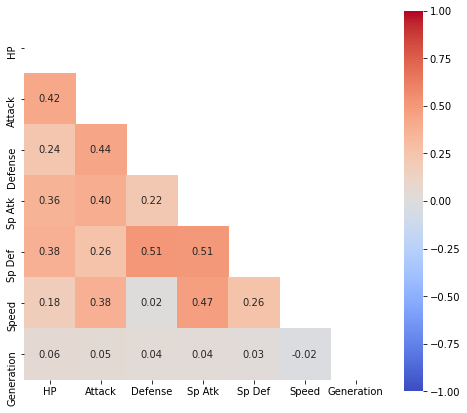

In [ ]:
plt.figure(figsize=(8,7))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1, vmin=-1, square=True, annot=True, fmt='.2f')



_Obtener columnas altamente correladas_

In [ ]:
(corr_matrix['Attack'].abs() > 0.4)

HP            False
Attack        False
Defense        True
Sp Atk        False
Sp Def        False
Speed         False
Generation    False
Name: Attack, dtype: bool

In [ ]:
(corr_matrix['Attack'].abs() > 0.9).any()

False

In [ ]:
drop_columns = [c for c in quantitative_vars if (corr_matrix[c].abs() > 0.9).any()]
drop_columns

[]

In [ ]:
# Imported functions

def corrank(X):
    import itertools
    df_correlaciones = pd.DataFrame([[(i,j),X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
    return df_correlaciones.sort_values(by='corr',ascending=False)
corrank(corr_matrix)

,pairs,corr
3,"(HP, Sp Def)",1.000000
15,"(Sp Atk, Sp Def)",1.000000
8,"(Attack, Sp Def)",1.000000
7,"(Attack, Sp Atk)",0.912482
1,"(HP, Defense)",0.820230
2,"(HP, Sp Atk)",0.817668
0,"(HP, Attack)",0.557017
11,"(Defense, Sp Atk)",0.512382
6,"(Attack, Defense)",0.137814
12,"(Defense, Sp Def)",-1.000000




Baja varianza

In [ ]:
num_cols = [ x[0] for x in pokemon_df.dtypes if x[1] in ['double', 'float', 'int']] 

for c in num_cols:
    if pokemon_df.select(F.variance(c)).collect()[0][0]<0.5:
        pokemon_df=pokemon_df.drop(c)



## Técnicas Gráficas (Opcional)

El método más sencillo de realizar gráficos en Spark es utilizando muestras.

 

__Histogramas y BoxPlots__

In [ ]:
susy_df = spark.read.csv(DATA_PATH + 'susy.csv', sep=',', inferSchema=True, header=True)

In [ ]:
susy_df.limit(10).toPandas()

,label,lepton1_pt,lepton1_eta,lepton1_phi,lepton2_pt,lepton2_eta,lepton2_phi,missing_energy_magnitude,missing_energy_phi,met_rel,axial_met,m_r,m_tr?,r,mt2,s_r,m_delta_r,dphi_r_b,cos(theta_r1)
0,1.0,1.667973,0.064191,-1.225171,0.506102,-3.389389812946319580e-01,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
1,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871216773986816e+00,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
2,1.0,0.381256,-0.976145,0.693152,0.448959,8.917528986930847168e-01,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
3,1.0,1.309996,-0.690089,-0.676259,1.589283,-6.933256387710571289e-01,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859
4,0.0,0.456398,1.099371,1.512453,0.751772,6.389670372009277344e-01,-0.742216,0.322601,1.321054,0.169502,0.359941,0.489256,0.416168,0.754829,0.303750,0.461067,0.345541,0.733242,0.186044
5,0.0,0.437818,-1.119883,-1.336823,0.502320,-1.717514872550964355e+00,1.017067,0.215619,-0.461200,0.323671,0.173626,0.411898,0.370525,0.798260,0.671369,0.385910,0.515522,0.479110,0.029058
6,0.0,0.571656,0.205696,0.425950,0.578514,9.273992180824279785e-01,-1.101478,0.116555,1.549753,0.174421,0.223450,0.523164,0.289889,0.491710,0.334593,0.514246,0.268207,0.315795,0.125728
7,1.0,2.112812,0.742983,-0.330539,0.805253,-2.888736501336097717e-02,-1.446679,2.299946,1.450429,2.989110,-1.894770,1.445125,2.548166,1.564721,2.393632,1.554566,2.148468,1.179117,0.688057
8,0.0,1.001869,-0.471788,0.555614,1.233368,1.255548357963562012e+00,-1.052491,0.437615,-1.333052,0.326858,-0.111678,1.435708,0.755201,0.466779,0.454541,1.446331,0.592259,1.325197,0.083014
9,0.0,0.840115,0.958249,-0.585658,1.317930,-1.063729524612426758e+00,1.246235,0.261865,-0.027341,0.330517,0.183190,1.557298,0.531022,0.302592,0.426702,1.564376,0.338552,1.137456,0.011040


In [ ]:
n_rows = susy_df.count()
n_rows

13161

In [ ]:
sample_data = susy_df.select('lepton1_pt').sample(False, fraction=10000/n_rows).toPandas()
sample_data.head(10)

,lepton1_pt
0,1.667973
1,0.444840
2,1.309996
3,0.437818
4,0.571656
5,0.840115
6,0.698336
7,0.578286
8,0.865126
9,0.679042


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


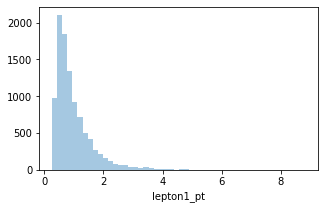

In [ ]:
plt.figure(figsize=(5,3))
sns.distplot(sample_data['lepton1_pt'], kde=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


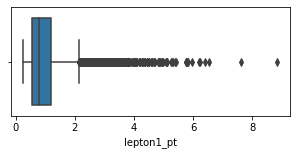

In [ ]:
plt.figure(figsize=(5,2))
sns.boxplot(sample_data['lepton1_pt'], orient='h')



__Scatter plot y Side-by-Side BoxPlot__

_Scatter_

In [ ]:
sample_data = susy_df.select('lepton1_pt', 'missing_energy_magnitude')\
                     .sample(False, fraction=10000/n_rows).toPandas()
sample_data.head(5)

,lepton1_pt,missing_energy_magnitude
0,1.667973,3.475464
1,0.381256,2.033060
2,1.309996,1.087562
3,0.456398,0.322601
4,0.437818,0.215619


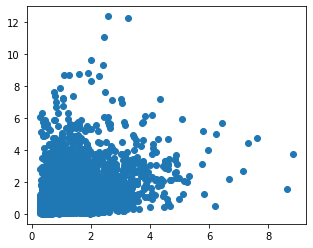

In [ ]:
plt.figure(figsize=(5,4))
plt.scatter(sample_data['lepton1_pt'], sample_data['missing_energy_magnitude'])



__Side-by-Side BoxPlot__

In [ ]:
sample_data = susy_df.select('lepton1_pt', 'label')\
                     .sample(False, fraction=10000/n_rows).toPandas()

sample_data.head(5)

,lepton1_pt,label
0,1.667973,1.0
1,0.444840,1.0
2,1.309996,1.0
3,0.456398,0.0
4,0.437818,0.0


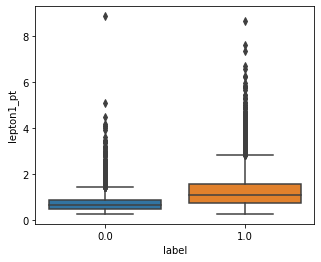

In [ ]:
plt.figure(figsize=(5,4))
sns.boxplot(x='label', y='lepton1_pt', data=sample_data, orient='v')



__Barplot__

Es posible precalcular los datos y por tanto no es necesario hacer un sampling.

In [ ]:
value_counts = pokemon_df.groupBy('Type 1').count().toPandas()
value_counts

,Type 1,count
0,Water,112
1,Poison,28
2,Steel,27
3,Rock,44
4,Ice,24
5,Ghost,32
6,Fairy,17
7,Psychic,57
8,Dragon,32
9,Flying,4


In [ ]:
value_counts = value_counts.sort_values('count')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text major ticklabel objects>)

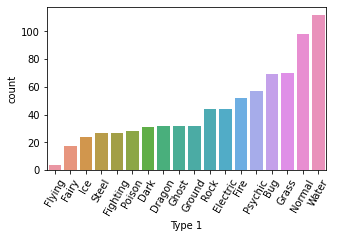

In [ ]:
plt.figure(figsize=(5,3))
sns.barplot(value_counts['Type 1'], value_counts['count'])
plt.xticks(rotation=60)



# Valores Atípicos

Una forma muy sencilla de eliminar outliers de forma analítica es aplicando el test de Tukey. 

Éste dice que se considera valor atípico a todo aquel que esté en alguna de las situaciones siguientes:

- Intervalo inferior para valor atípico: $ x < Q_1 - 1.5\cdot IQR $
- Intervalo superior para valor atípico: $ x > Q_3 + 1.5 \cdot IQR$
- Intervalo inferior para valor atípico extremo: $ x < Q_1 - 3\cdot IQR $
- Intervalo superior para valor atípico extremo: $ x >Q_3 + 3\cdot IQR$

Si la distribución es normal, entonces queda de la siguiente forma:

- Intervalo inferior para valor atípico: $ x < -\sigma $
- Intervalo superior para valor atípico: $ x > \sigma $
- Intervalo inferior para valor atípico extremo: $ x < - 2\cdot \sigma $
- Intervalo superior para valor atípico extremo: $ x > 2\cdot \sigma $

Vamos a crear una función para identifucar outliers usando el test de Tukey.



_Calcula el rango intercuartilico y umbrales_

In [ ]:
q1, q3 = susy_df.approxQuantile('lepton1_pt', [0.25, 0.75], 0.01)
q1, q3

(0.553522527217865, 1.1924456357955933)

In [ ]:
IQR = q3 - q1
IQR

0.6389231085777283

In [ ]:
min_thresh = q1 - 1.5 * IQR
max_thresh = q3 + 1.5 * IQR

min_thresh, max_thresh

(-0.4048621356487274, 2.1508302986621857)



_Crea una función._

In [ ]:
def remove_tukey_outliers(df, col):
    """
    Returns a new dataframe with outliers removed on column 'col' usting Tukey test
    """
    
    q1, q3 = df.approxQuantile(col, [0.25, 0.75], 0.01)
    IQR = q3 - q1
    
    min_thresh = q1 - 1.5 * IQR
    max_thresh = q3 + 1.5 * IQR
    
    print(df.count())
    df_no_outliers = df.filter(F.col(col).between(min_thresh, max_thresh))
    
    return df_no_outliers



Elimina los outliers usando la funcion anterior para la columna `lepton1_pt`

In [ ]:
susy_no_outliers = remove_tukey_outliers(susy_df, 'lepton1_pt')

13161




Comprueba el porcentaje de outliers de la columna `lepton1_pt`

In [ ]:
n_rows_no = susy_no_outliers.count()
perc_outliers = 100 * (n_rows - n_rows_no) / n_rows

In [ ]:
print('{} has {:.2f}% outliers'.format('lepton1_pt', perc_outliers))

lepton1_pt has 5.91% outliers
